# Encoding of space, hippocampus (CA1)

In this notebook, we show how to: 

- use CEBRA on the hippocampus data (as shown in Fig. 1, 2).
- use the infoNCE loss with CEBRA.

More specifically, this is a mega-notebook, containing all the informations presented in [Hypothesis-driven analysis](https://cebra.ai/docs/demo_notebooks/Demo_hypothesis_testing.html), [Consistency](https://cebra.ai/docs/demo_notebooks/Demo_consistency.html), [Decoding](https://cebra.ai/docs/demo_notebooks/Demo_decoding.html) and [Topological data analysis](https://cebra.ai/docs/demo_notebooks/Demo_cohomology.html) into a single demo notebook. We recommand that you go through those individual notebooks instead, as they present some of the most recently implemented helper functions for plotting, saving models, etc.

**Install note**

- Be sure you have demo dependencies installed to use this notebook: 

In [ ]:
!pip install 'cebra[dev,demos]'

In [27]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd

### Load the data:

In [3]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:08<00:00, 1.20MB/s]

Download complete. Dataset saved in 'data\rat_hippocampus\achilles.jl'


In [32]:
# read the achilles.jl data
# change the hippocampus_pos data to a structure that can be easily used, it contains 'neural', 'discrete', and 'continuous' data
# the 'neural' data is a list of spike times for each neuron
# the 'discrete' data is a list of discrete events
# the 'continuous' data is a list of continuous data
neural_data = hippocampus_pos.neural.numpy()
continuous_data = hippocampus_pos.continuous_index.numpy()


In [35]:
print(neural_data.shape)

# Put neural_data and continuous_data into a dictionary and export it to a npz file
np.savez('hippocampus_data.npz', neural_data=neural_data, continuous_data=continuous_data)

(10178, 120)


In [36]:
# Load the data from the npz file
data = np.load('hippocampus_data.npz')
neural_data = data['neural_data']
continuous_data = data['continuous_data']

### Visualize the data:

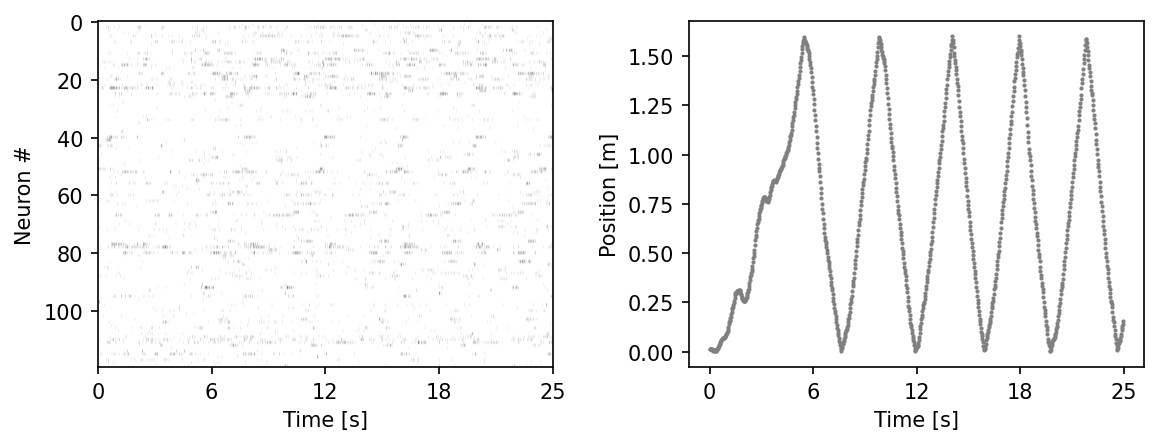

In [38]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)

ax = plt.subplot(121)
ax.imshow(neural_data[:1000].T, aspect='auto', cmap='gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype=int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), continuous_data[:1000, 0], c='gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype=int))

plt.show()

In [5]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

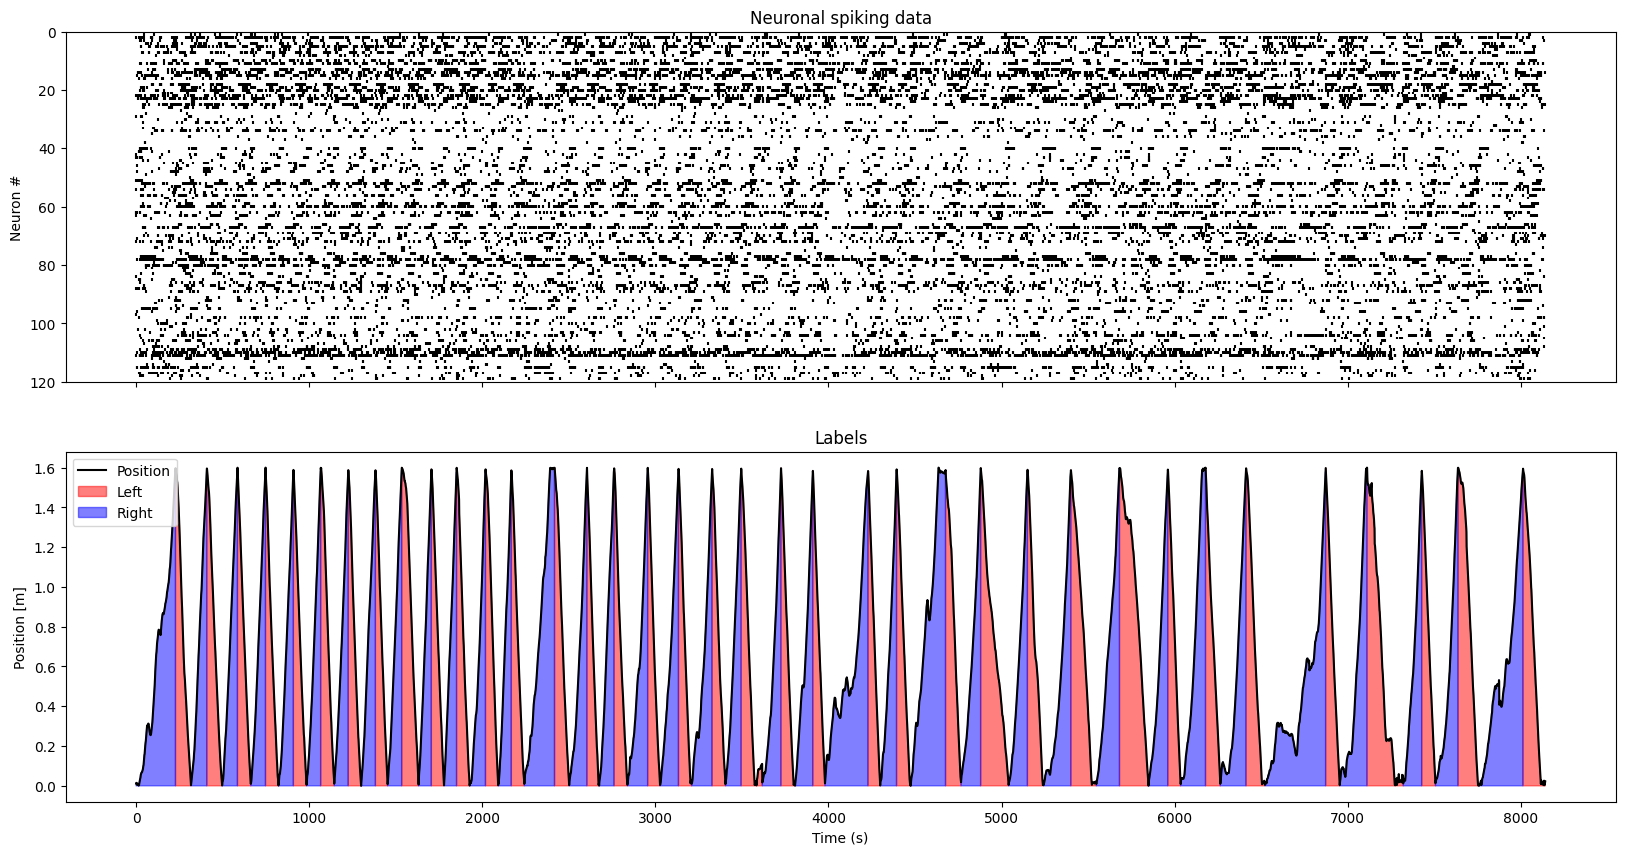

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)

for i in range(neural_train.shape[1]):
    spike_times = np.where(neural_train[:,i] > 0)[0]
    ax1.eventplot(spike_times, lineoffsets=i, colors='black')

ax1.set_ylabel('Neuron #')
ax1.set_title('Neuronal spiking data')
# invert y-axis
ax1.set_ylim(neural_train.shape[1], 0)

ax2.plot(label_train[:,0], color='black')
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,2]==1, color='red', alpha=0.5)
ax2.fill_between(range(len(label_train)), label_train[:,0], where=label_train[:,1]==1, color='blue', alpha=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position [m]')
ax2.set_title('Labels')
plt.legend(['Position', 'Left', 'Right'])

plt.show()

### Train CEBRA-Behavior with position, or direction, and/or both variables

In [12]:
print(neural_train.shape)

max_iterations = 500 #default is 5000.
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

(8142, 120)


In [13]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [ ]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(neural_train, label_train)

# Train CEBRA-Behavior models with position variable.
cebra_pos_model.fit(neural_train, label_train[:,0])

# Train CEBRA-Behavior models with direction variable.
cebra_dir_model.fit(neural_train, label_train[:,1])

pos: -0.8335 neg:  6.4392 total:  5.6057 temperature:  1.0000: 100%|██████████| 500/500 [00:07<00:00, 63.71it/s]
pos: -0.8255 neg:  6.4962 total:  5.6707 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 73.08it/s]
pos: -0.7847 neg:  6.4728 total:  5.6881 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 73.79it/s]


### Train shuffled CEBRA-Behavior with position, direction variables and both

In [15]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [16]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(label_train)
shuffled_pos = np.random.permutation(label_train[:,0])
shuffled_dir = np.random.permutation(label_train[:,1])


# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(neural_train, shuffled_posdir)

cebra_pos_shuffled_model.fit(neural_train, shuffled_pos)

cebra_dir_shuffled_model.fit(neural_train, shuffled_dir)


  0%|          | 0/500 [00:00<?, ?it/s]

pos: -0.4108 neg:  6.5543 total:  6.1434 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 72.79it/s]
pos: -0.4407 neg:  6.5624 total:  6.1218 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 75.73it/s]
pos: -0.5179 neg:  6.5185 total:  6.0006 temperature:  1.0000: 100%|██████████| 500/500 [00:06<00:00, 74.51it/s]


CEBRA(batch_size=512, max_iterations=500, model_architecture='offset10-model',
      output_dimension=32, temperature=1, verbose=True)

In [18]:
# We get train set embedding and test set embedding.

cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)

# ... and similarily for models with shuffled variables

cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(neural_train)
cebra_posdir_shuffled_test = cebra_posdir_shuffled_model.transform(neural_test)

cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(neural_train)
cebra_pos_shuffled_test = cebra_pos_shuffled_model.transform(neural_test)

cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(neural_train)
cebra_dir_shuffled_test = cebra_dir_shuffled_model.transform(neural_test)

In [20]:
import sklearn.metrics

# Define decoding function with kNN decoder. For a simple demo, we will use the fixed number of neighbors 36.
def decoding_pos_dir(embedding_train, embedding_test, label_train, label_test):
   pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
   dir_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

   pos_decoder.fit(embedding_train, label_train[:,0])
   dir_decoder.fit(embedding_train, label_train[:,1])

   pos_pred = pos_decoder.predict(embedding_test)
   dir_pred = dir_decoder.predict(embedding_test)

   prediction = np.stack([pos_pred, dir_pred],axis = 1)

   test_score = sklearn.metrics.r2_score(label_test[:,:2], prediction)
   pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
   pos_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:,0])

   return test_score, pos_test_err, pos_test_score

In [21]:
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)

cebra_posdir_shuffled_decode = decoding_pos_dir(cebra_posdir_shuffled_train, cebra_posdir_shuffled_test, label_train, label_test)
cebra_pos_shuffled_decode = decoding_pos_dir(cebra_pos_shuffled_train, cebra_pos_shuffled_test, label_train, label_test)
cebra_dir_shuffled_decode = decoding_pos_dir(cebra_dir_shuffled_train, cebra_dir_shuffled_test, label_train, label_test)

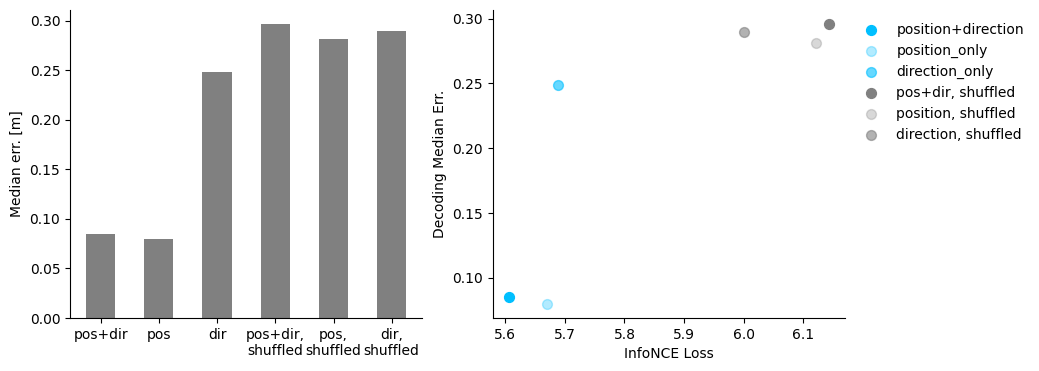

In [22]:
fig = plt.figure(figsize=(10,4))

ax1= plt.subplot(121)
ax1.bar(np.arange(6),
        [cebra_posdir_decode[1], cebra_pos_decode[1], cebra_dir_decode[1],
         cebra_posdir_shuffled_decode[1], cebra_pos_shuffled_decode[1], cebra_dir_shuffled_decode[1]],
         width = 0.5, color = 'gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(cebra_posdir_model.state_dict_['loss'][-1],cebra_posdir_decode[1], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(cebra_pos_model.state_dict_['loss'][-1],cebra_pos_decode[1], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(cebra_dir_model.state_dict_['loss'][-1],cebra_dir_decode[1], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(cebra_posdir_shuffled_model.state_dict_['loss'][-1],cebra_posdir_shuffled_decode[1], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(cebra_pos_shuffled_model.state_dict_['loss'][-1],cebra_pos_shuffled_decode[1], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(cebra_dir_shuffled_model.state_dict_['loss'][-1],cebra_dir_shuffled_decode[1], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_hippocampus(ax1, cebra_posdir, hippocampus_pos.continuous_index)
ax2=plot_hippocampus(ax2, cebra_posdir_shuffled, hippocampus_pos.continuous_index)
ax3=plot_hippocampus(ax3, cebra_time, hippocampus_pos.continuous_index)
ax4=plot_hippocampus(ax4, cebra_hybrid, hippocampus_pos.continuous_index)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
plt.show()

### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.
- For reproducing Figure 2, we use dimension 3 for the infoNCE loss. You can otherwise set it higher.

In [3]:
max_iterations = 10000 #default is 5000.
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

In [4]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

### We train the model with neural data and the behavior variable including position and direction. 

In [5]:
cebra_posdir3_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir3 = cebra_posdir3_model.transform(hippocampus_pos.neural)

pos:  0.1079 neg:  5.4144 total:  5.5223 temperature:  1.0000: 100%|█████| 10000/10000 [03:14<00:00, 51.49it/s]


### CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

In [7]:
cebra_posdir_shuffled3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

- Now we train the model with shuffled behavior variable. 

In [8]:
### Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())
cebra_posdir_shuffled3_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_posdir_shuffled3 = cebra_posdir_shuffled3_model.transform(hippocampus_pos.neural)

pos:  0.3269 neg:  5.8227 total:  6.1496 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:21<00:00, 49.69it/s]


### CEBRA-Time: Train a model that uses time without the behavior information. 
- We can use CEBRA -Time mode by setting conditional = 'time'

In [9]:
cebra_time3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [10]:
cebra_time3_model.fit(hippocampus_pos.neural)
cebra_time3 = cebra_time3_model.transform(hippocampus_pos.neural)

pos:  0.0245 neg:  5.4787 total:  5.5032 temperature:  1.1200: 100%|██████████████████████████████████| 10000/10000 [03:13<00:00, 51.63it/s]


### CEBRA-Hybrid: Train a model that uses both time and positional information. 

In [11]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [12]:
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_hybrid = cebra_hybrid_model.transform(hippocampus_pos.neural)

behavior_pos:  0.0975 behavior_neg:  5.4146 behavior_total:  5.5121 time_pos:  0.0819 time_neg:  5.4146 time_total:  5.4965: 100%|█| 10000/1


### Visualize the embeddings from CEBRA-Behavior, CEBRA-Time and CEBRA-Hybrid

In [13]:
def plot_hippocampus(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = label[:,1] == 1
    l_ind = label[:,2] == 1
    
    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'
    
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [r_ind,idx1], 
               embedding [r_ind,idx2], 
               embedding [r_ind,idx3], 
               c=r_c,
               cmap=r_cmap, s=0.5)
    l=ax.scatter(embedding [l_ind,idx1], 
               embedding [l_ind,idx2], 
               embedding [l_ind,idx3], 
               c=l_c,
               cmap=l_cmap, s=0.5)
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
        
    return ax

<IPython.core.display.Javascript object>


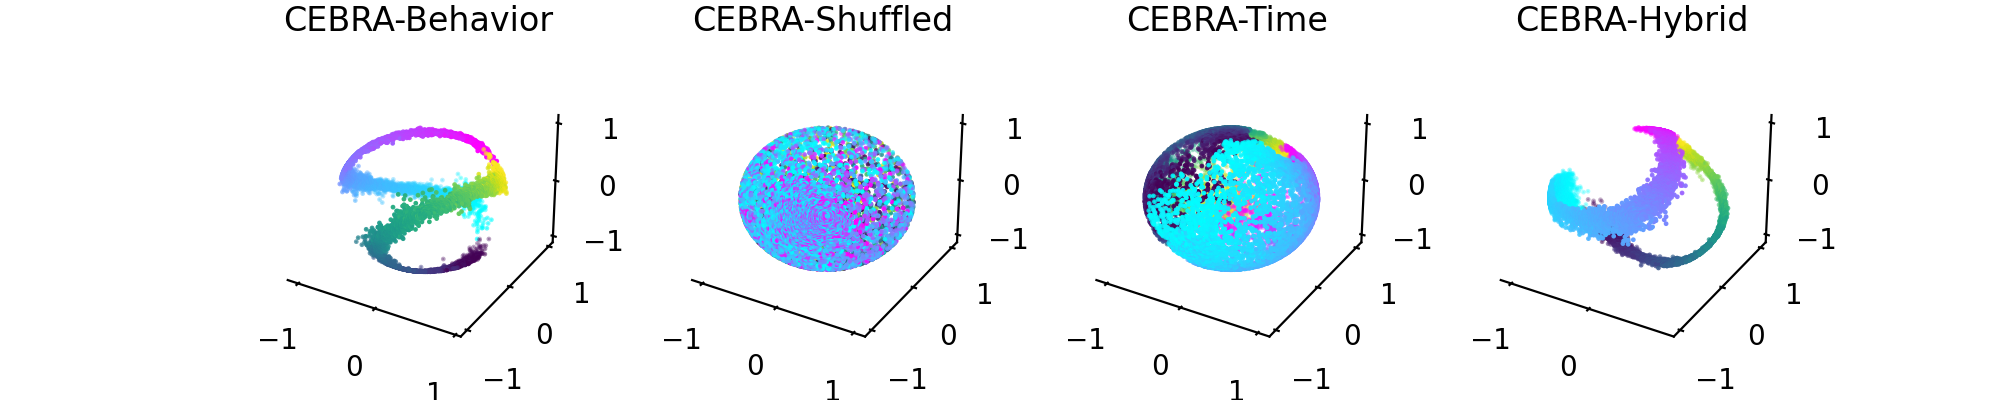

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_hippocampus(ax1, cebra_posdir3, hippocampus_pos.continuous_index)
ax2=plot_hippocampus(ax2, cebra_posdir_shuffled3, hippocampus_pos.continuous_index)
ax3=plot_hippocampus(ax3, cebra_time3, hippocampus_pos.continuous_index)
ax4=plot_hippocampus(ax4, cebra_hybrid, hippocampus_pos.continuous_index)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
plt.show()

### Hypothesis Testing: Train models with different hypothesis on position encoding of hippocampus. 
- We will compare CEBRA-Behavior models trained with only position, only direction, both and the control models with shuffled behavior variables. 

- Here, we use the set model dimension; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

- For the purpose of decoding later, we will use a splitted data (80% train, 20% test) and only use train set to train the models.

In [15]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]
    
    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

In [16]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [17]:
# Train CEBRA-Behavior models with position, direction variable or both.
# We get train set embedding and test set embedding. 

cebra_posdir_model.fit(neural_train, label_train)
cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_model.fit(neural_train, label_train[:,0])
cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_model.fit(neural_train, label_train[:,1])
cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)

pos:  0.1131 neg:  5.3916 total:  5.5047 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:24<00:00, 48.81it/s]
pos:  0.1252 neg:  5.4816 total:  5.6069 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:25<00:00, 48.66it/s]
pos:  0.0523 neg:  5.5970 total:  5.6493 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:07<00:00, 53.30it/s]


### Train control models with shuffled behavior variables. 

In [18]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [19]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(label_train)
shuffled_pos = np.random.permutation(label_train[:,0])
shuffled_dir = np.random.permutation(label_train[:,1])

# Train the models with shuffled behavior variables and get train/test embeddings
cebra_posdir_shuffled_model.fit(neural_train, shuffled_posdir)
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(neural_train)
cebra_posdir_shuffled_test = cebra_posdir_shuffled_model.transform(neural_test)

cebra_pos_shuffled_model.fit(neural_train, shuffled_pos)
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(neural_train)
cebra_pos_shuffled_test = cebra_pos_shuffled_model.transform(neural_test)

cebra_dir_shuffled_model.fit(neural_train, shuffled_dir)
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(neural_train)
cebra_dir_shuffled_test = cebra_dir_shuffled_model.transform(neural_test)

pos:  0.2638 neg:  5.8669 total:  6.1307 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [02:52<00:00, 58.06it/s]
pos:  0.3004 neg:  5.8341 total:  6.1345 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:24<00:00, 48.86it/s]
pos:  0.1932 neg:  5.8094 total:  6.0027 temperature:  1.0000: 100%|██████████████████████████████████| 10000/10000 [03:23<00:00, 49.03it/s]


### Visualize embeddings from different hypothesis

In [20]:
cebra_pos_all = cebra_pos_model.transform(hippocampus_pos.neural)
cebra_dir_all = cebra_dir_model.transform(hippocampus_pos.neural)
cebra_posdir_all = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_all = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)
cebra_dir_shuffled_all = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)
cebra_posdir_shuffled_all = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

<IPython.core.display.Javascript object>


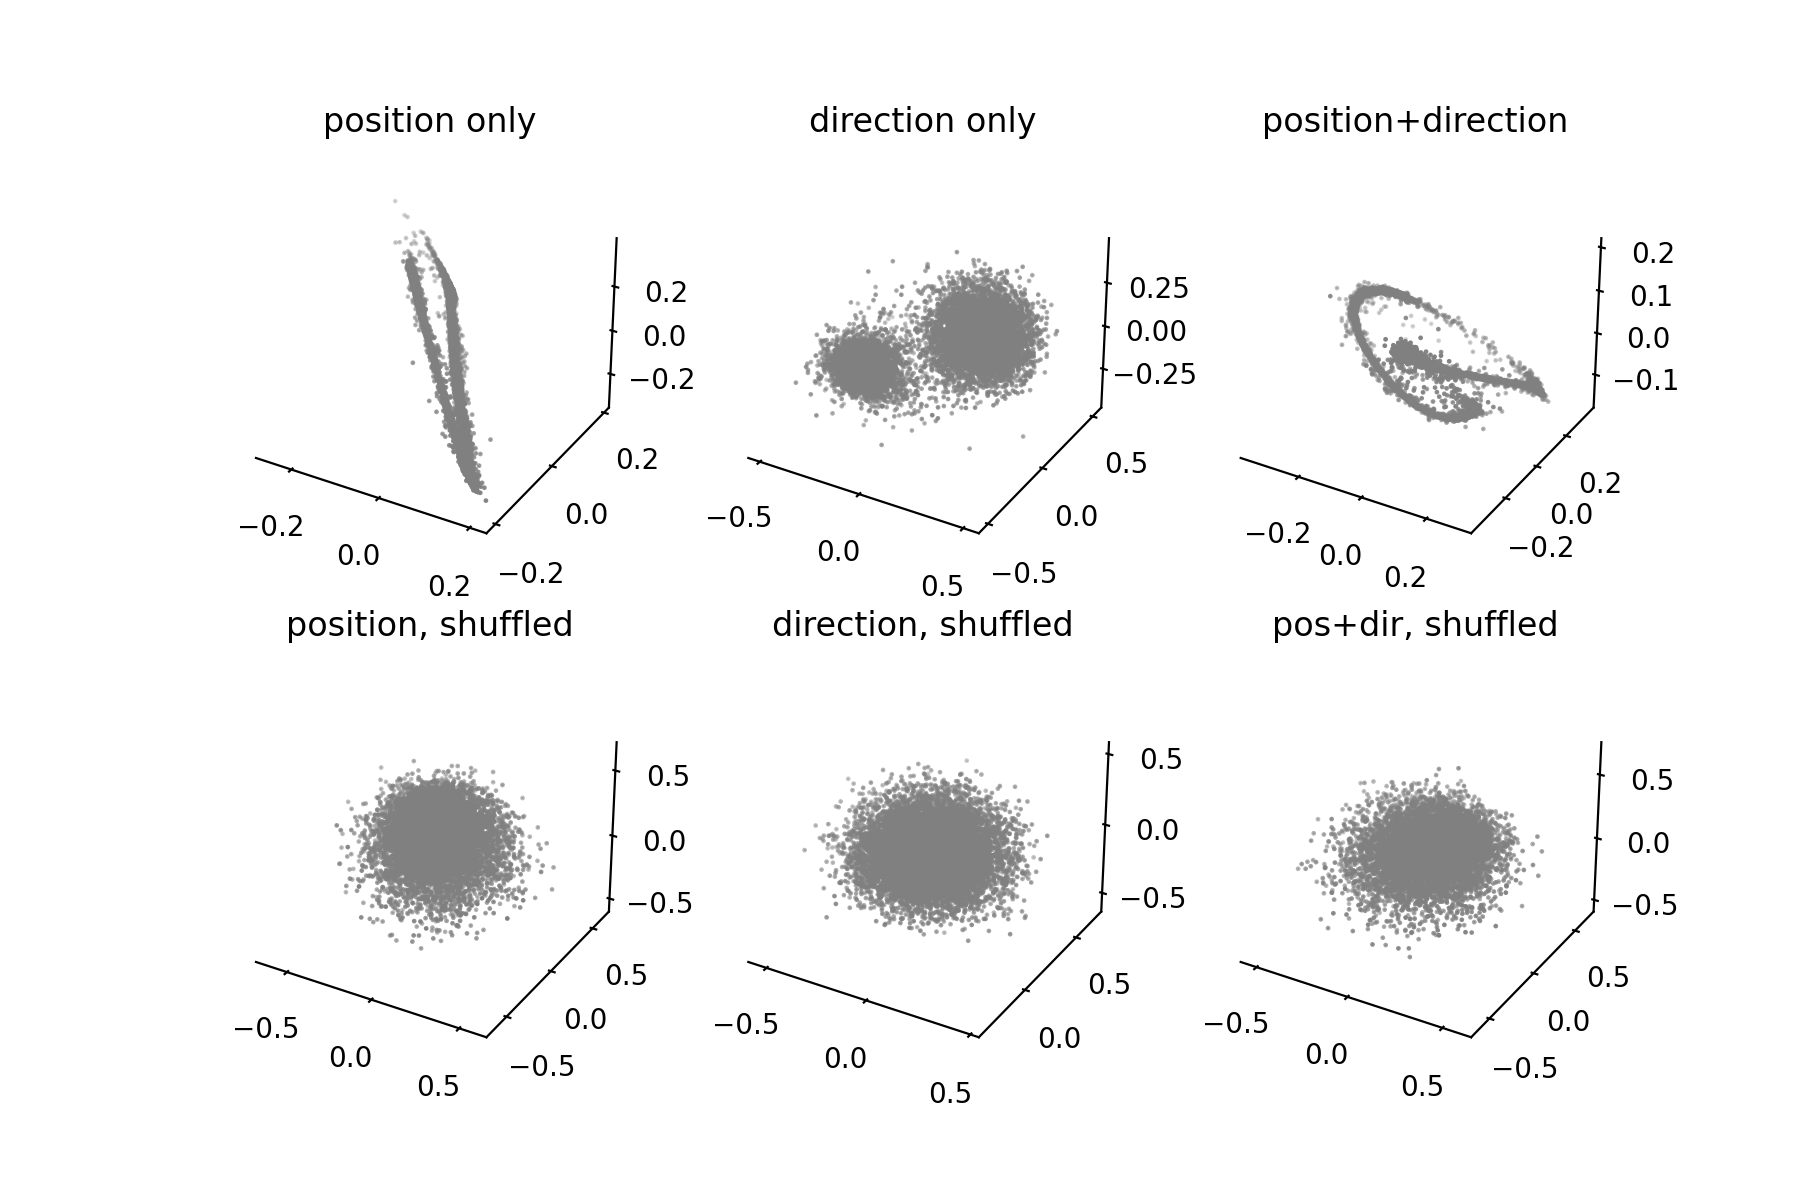

In [21]:
fig=plt.figure(figsize=(9,6))
ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')

ax1=plot_hippocampus(ax1, cebra_pos_all, hippocampus_pos.continuous_index, gray=True)
ax2=plot_hippocampus(ax2, cebra_dir_all, hippocampus_pos.continuous_index, gray=True)
ax3=plot_hippocampus(ax3, cebra_posdir_all,hippocampus_pos.continuous_index, gray=True)
ax4=plot_hippocampus(ax4, cebra_pos_shuffled_all, hippocampus_pos.continuous_index, gray=True)
ax5=plot_hippocampus(ax5, cebra_dir_shuffled_all, hippocampus_pos.continuous_index, gray=True)
ax6=plot_hippocampus(ax6, cebra_posdir_shuffled_all, hippocampus_pos.continuous_index, gray=True)

ax1.set_title('position only')
ax2.set_title('direction only')
ax3.set_title('position+direction')
ax4.set_title('position, shuffled')
ax5.set_title('direction, shuffled')
ax6.set_title('pos+dir, shuffled')

def ax_lim(ax):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
plt.show()

### Visualize the loss of models trained with different hypothesis

<IPython.core.display.Javascript object>


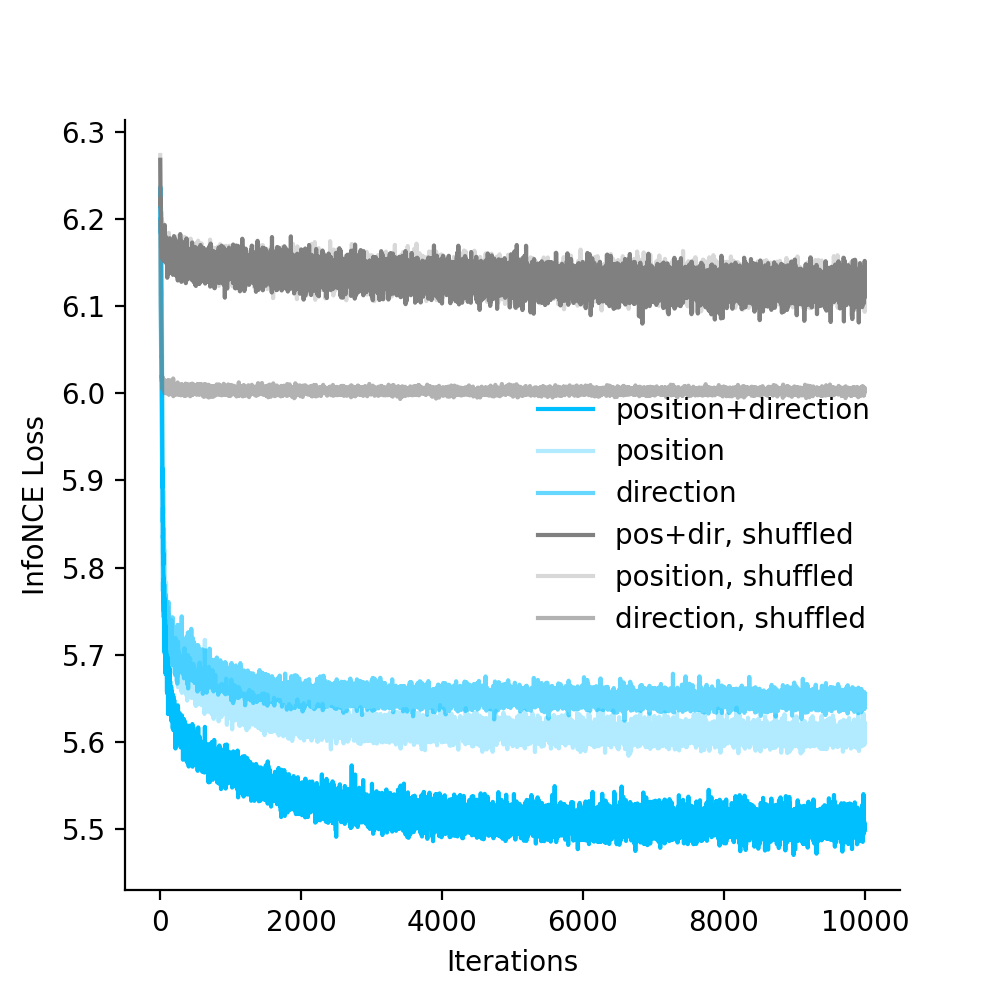

In [22]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(cebra_posdir_model.state_dict_['loss'], c='deepskyblue', label = 'position+direction')
ax.plot(cebra_pos_model.state_dict_['loss'], c='deepskyblue', alpha = 0.3, label = 'position')
ax.plot(cebra_dir_model.state_dict_['loss'], c='deepskyblue', alpha=0.6,label = 'direction')
ax.plot(cebra_posdir_shuffled_model.state_dict_['loss'], c='gray', label = 'pos+dir, shuffled')
ax.plot(cebra_pos_shuffled_model.state_dict_['loss'], c='gray', alpha = 0.3, label = 'position, shuffled')
ax.plot(cebra_dir_shuffled_model.state_dict_['loss'],c='gray', alpha=0.6,label = 'direction, shuffled')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.show()

### Decoding: we evaluate decoding performance of the different hypothesis models.

In [23]:
# Define decoding function with kNN decoder. For a simple demo, we will use the fixed number of neighbors 36.

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics

def decoding_pos_dir(emb_train, emb_test, label_train, label_test, n_neighbors=36):
    pos_decoder = KNeighborsRegressor(n_neighbors, metric = 'cosine')
    dir_decoder = KNeighborsClassifier(n_neighbors, metric = 'cosine')
    
    pos_decoder.fit(emb_train, label_train[:,0])
    dir_decoder.fit(emb_train, label_train[:,1])
    
    pos_pred = pos_decoder.predict(emb_test)
    dir_pred = dir_decoder.predict(emb_test)
    
    prediction =np.stack([pos_pred, dir_pred],axis = 1)

    test_score = sklearn.metrics.r2_score(label_test[:,:2], prediction)
    pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
    pos_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:,0])
    
    return test_score, pos_test_err, pos_test_score

- Decode the position and direction from the trained hypothesis models

In [24]:
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)
cebra_posdir_shuffled_decode = decoding_pos_dir(cebra_posdir_shuffled_train, cebra_posdir_shuffled_test, label_train, label_test)
cebra_pos_shuffled_decode = decoding_pos_dir(cebra_pos_shuffled_train, cebra_pos_shuffled_test, label_train, label_test)
cebra_dir_shuffled_decode = decoding_pos_dir(cebra_dir_shuffled_train, cebra_dir_shuffled_test, label_train, label_test)


### Visualize the decoding results and loss - decoding performance

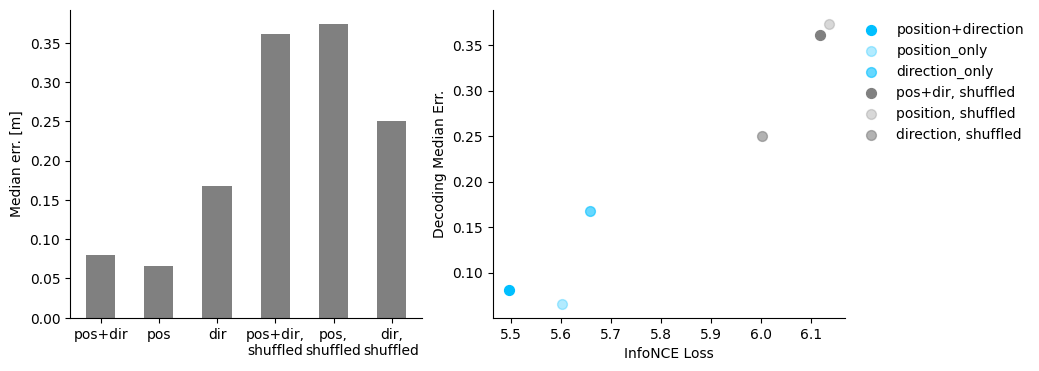

In [ ]:
fig = plt.figure(figsize=(10,4))
ax1= plt.subplot(121)
ax1.bar(np.arange(6), 
        [cebra_posdir_decode[1], cebra_pos_decode[1], cebra_dir_decode[1], 
         cebra_posdir_shuffled_decode[1], cebra_pos_shuffled_decode[1], cebra_dir_shuffled_decode[1]],
         width = 0.5, color = 'gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(cebra_posdir_model.state_dict_['loss'][-1],cebra_posdir_decode[1], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(cebra_pos_model.state_dict_['loss'][-1],cebra_pos_decode[1], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(cebra_dir_model.state_dict_['loss'][-1],cebra_dir_decode[1], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(cebra_posdir_shuffled_model.state_dict_['loss'][-1],cebra_posdir_shuffled_decode[1], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(cebra_pos_shuffled_model.state_dict_['loss'][-1],cebra_pos_shuffled_decode[1], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(cebra_dir_shuffled_model.state_dict_['loss'][-1],cebra_dir_shuffled_decode[1], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()